# **Customer Churn Prediction (PyTorch Pipeline)**

Dataset: [Telco Customer Churn](https://www.kaggle.com/datasets/blastchar/telco-customer-churn)


## Objective
Churn Prediction for optimized retention intitiatives and decreasing loss in revenue.

## Problem Statement

The telecommunications provider is facing customer churn. This directly decreases recurring revenue and increases acquisition expenditure to replaces the lost individuals. A competitive telecom market with closely priced offerings and similar products, un-manageable churn affects the market share and customer lifetime value. This makes early detection and interference a priority in terms of a strategy.



### Advantages (How the company benefits?)
1. A solid churn prediction model allows proactive retention initiatives focused on high risk/value individuals.
2. This prioritization imporves retention ROI by reducing non-necessary spendings on low risk individuals.
3. Lowers turnover leakage by retaining the possible churners.
4. Overtime it allows the company to quantify saved revenue, efficiency of campaigns and decrease in churn rates to analyze financial impact.

### Data Collection Strategy
* Billing or contract
* Services
* Payments
* Tenure
* Charges
* Support signals (with engineered features)

### ML Framing
* Binary Classification with probability outputs.
* Ephasize F1/Recall due to class imbalance and higher cost of missed churn individuals.

### Outcome

* A deployable model that ranks individuals(customers) by risk of churn.
* Supports threshold backed outcome decisions.
* Quantification of financial impact by revenue saved vs cost of outreach.

## Setting up Environment

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)
torch.manual_seed(42)


## Datastet
* Data Source: [Telco Customer Churn](https://www.kaggle.com/datasets/blastchar/telco-customer-churn)

* Target map: 'Yes" = 1 , 'No' = 0

* ID: Dropping CustomerID to avoid leakage or overfitting

In [ ]:
dataset = "/content/WA_Fn-UseC_-Telco-Customer-Churn.csv"

df = pd.read_csv(dataset)
print("Shape:", df.shape)
display(df.head())
df.info()

if "TotalCharges" in df.columns:
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

if "Churn" in df.columns:
    df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0}).astype(int)
else:
    raise ValueError("Expected 'Churn' column not found.")


Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## Exploratory Data Analysis (EDA) Objectives:
* Inspecting missing values, duplicates to analyze data quality
* Summarization of numerical distribution and categoricals to go ahead with pre-processing.
* Confirming target imbalance and noting implications for analysis.

In [ ]:
print("Missing values (desc):")
display(df.isnull().sum().sort_values(ascending=False))

print("Duplicate rows:", df.duplicated().sum())

print("Target distribution (Churn):")
display(df["Churn"].value_counts(normalize=True))

display(df.describe(include=[np.number]).T)

cat_cols_preview = [c for c in df.select_dtypes(include=["object","category"]).columns
                    if df[c].nunique() <= 20]
for c in cat_cols_preview[:10]:
    print(f"\n{c}:")
    display(df[c].value_counts(dropna=False).head(20))


Missing values (desc):


,0
TotalCharges,11
gender,0
SeniorCitizen,0
Partner,0
customerID,0
Dependents,0
tenure,0
MultipleLines,0
PhoneService,0
OnlineSecurity,0


Duplicate rows: 0
Target distribution (Churn):


,proportion
Churn,
0,0.73463
1,0.26537


,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.00,0.000,0.0000,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.00,29.000,55.0000,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.350,89.8500,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.45,1397.475,3794.7375,8684.80
Churn,7043.0,0.265370,0.441561,0.00,0.00,0.000,1.0000,1.00



gender:


,count
gender,
Male,3555
Female,3488



Partner:


,count
Partner,
No,3641
Yes,3402



Dependents:


,count
Dependents,
No,4933
Yes,2110



PhoneService:


,count
PhoneService,
Yes,6361
No,682



MultipleLines:


,count
MultipleLines,
No,3390
Yes,2971
No phone service,682



InternetService:


,count
InternetService,
Fiber optic,3096
DSL,2421
No,1526



OnlineSecurity:


,count
OnlineSecurity,
No,3498
Yes,2019
No internet service,1526



OnlineBackup:


,count
OnlineBackup,
No,3088
Yes,2429
No internet service,1526



DeviceProtection:


,count
DeviceProtection,
No,3095
Yes,2422
No internet service,1526



TechSupport:


,count
TechSupport,
No,3473
Yes,2044
No internet service,1526


### Data Quality

* One of the issues observed was that TotalCharges requires numeric coercion and imputation for blanks.
* Imbalance in churn. Churn is generally the minority class.

## Preprocessing

For Categorical:
* Trim Whitespace
* One-Hot Encoding
* Ignoring catergories unseen in test by creation of a consistent column set.


For Numerical:
* Median Imputation
* Z-score scaling

For Split:

* Stratified train/split to retain Churn ratio.

In [ ]:
def normalize_str(s: pd.Series):
    return s.astype(str).str.strip()

df_clean = df.copy()
for c in df_clean.select_dtypes(include=["object"]).columns:
    df_clean[c] = normalize_str(df_clean[c])
print("Categoricals normalized.")


Categoricals normalized.


## Feature Engineering

* IsNewCustomer helps capture early churn.
* ChargeRatio = TotalCharges/MonthlyCharges shows a payment pattern and duration.
* Contract risk and Automatic Payment risk(autopay) can proxy commitment and friction.

In [ ]:
df_fe = df_clean.copy()

if "tenure" in df_fe.columns:
    df_fe["IsNewCustomer"] = (df_fe["tenure"] <= 1).astype(int)

if {"MonthlyCharges","TotalCharges"}.issubset(df_fe.columns):
    with np.errstate(divide="ignore", invalid="ignore"):
        df_fe["ChargeRatio"] = df_fe["TotalCharges"] / df_fe["MonthlyCharges"].replace(0, np.nan)
        df_fe["ChargeRatio"] = df_fe["ChargeRatio"].fillna(0)

if "Contract" in df_fe.columns:
    df_fe["ContractIsMonthToMonth"] = df_fe["Contract"].str.contains("Month-to-month", case=False).astype(int)
if "PaymentMethod" in df_fe.columns:
    df_fe["IsAutoPay"] = df_fe["PaymentMethod"].str.contains("automatic", case=False, na=False).astype(int)

print("Engineered features added if columns exist.")


Engineered features added if columns exist.


## Experiment Setup

Split: 80/20 Stratified Train/Test.

Models used:
* Model 1 PyTorch MLP (baseline).
* Model 2 PyTorch MLP (class-weighted loss).

Optimization: Adam, BCEWithLogitsLoss, small number of epochs for a first pass, track/train loss.


Train/Test Split

In [ ]:
drop_like_ids = [c for c in df_fe.columns if c.lower() in ["customerid","customer_id","id"]]
TARGET = "Churn"

X = df_fe.drop(columns=drop_like_ids + [TARGET])
y = df_fe[TARGET].copy()

X_train_df, X_test_df, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print("Train:", X_train_df.shape, "Test:", X_test_df.shape)


Train: (5634, 23) Test: (1409, 23)


## Preprocessing


### Identification of Numerical and Categorical


In [ ]:
num_cols = X_train_df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train_df.select_dtypes(exclude=[np.number]).columns.tolist()
print("Numeric:", len(num_cols), "| Categorical:", len(cat_cols))


Numeric: 8 | Categorical: 15


### Imputation of numerics with median

In [ ]:
num_medians = X_train_df[num_cols].median()
X_train_num = X_train_df[num_cols].fillna(num_medians)
X_test_num  = X_test_df[num_cols].fillna(num_medians)


 ### Scaling numbers (z-score using train stats)

In [ ]:
num_means = X_train_num.mean()
num_stds  = X_train_num.std().replace(0, 1.0)
X_train_num = (X_train_num - num_means) / num_stds
X_test_num  = (X_test_num  - num_means) / num_stds

### One hot encoding for categoricals

In [ ]:
def fit_ohe(df_cat: pd.DataFrame):
    cats = {c: sorted(df_cat[c].dropna().unique().tolist()) for c in df_cat.columns}
    return cats

def transform_ohe(df_cat: pd.DataFrame, cats_fit: dict):

    out_parts = []
    for c, cat_list in cats_fit.items():
        if c not in df_cat.columns:
            out_parts.append(np.zeros((len(df_cat), len(cat_list))))
            continue
        col = df_cat[c].astype("category")
        col = col.cat.set_categories(cat_list)
        ohe = pd.get_dummies(col, prefix=c)
        needed_cols = [f"{c}_{k}" for k in cat_list]
        for missing in set(needed_cols) - set(ohe.columns):
            ohe[missing] = 0
        ohe = ohe[needed_cols]
        out_parts.append(ohe.values)
    return np.concatenate(out_parts, axis=1) if len(out_parts) else np.empty((len(df_cat), 0))

cats_fit = fit_ohe(X_train_df[cat_cols]) if len(cat_cols) else {}

X_train_cat = transform_ohe(X_train_df[cat_cols], cats_fit) if len(cat_cols) else np.empty((len(X_train_df),0))
X_test_cat  = transform_ohe(X_test_df[cat_cols], cats_fit) if len(cat_cols) else np

### Concatenate numerical + Categorical arrays

In [ ]:
def fit_ohe(df_cat: pd.DataFrame):
    cats = {c: sorted(df_cat[c].dropna().unique().tolist()) for c in df_cat.columns}
    return cats
X_train_np = np.concatenate([X_train_num.values, X_train_cat], axis=1)
X_test_np  = np.concatenate([X_test_num.values,  X_test_cat],  axis=1)

### Converting to tensors

In [ ]:
X_train_t = torch.tensor(X_train_np, dtype=torch.float32)
X_test_t  = torch.tensor(X_test_np,  dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_t  = torch.tensor(y_test.values,  dtype=torch.float32).view(-1, 1)


### Torch Dataset and Loaders

In [ ]:
BATCH_SIZE = 64

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds  = TensorDataset(X_test_t,  y_test_t)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

len(train_loader), len(test_loader)


(89, 23)

### PyTorch MLP for churn (Binary Classification)

In [ ]:
class ChurnNet(nn.Module):
    def __init__(self, in_features, hidden=[128, 64], dropout=0.3):
        super().__init__()
        layers = []
        prev = in_features
        for h in hidden:
            layers += [nn.Linear(prev, h), nn.ReLU(), nn.BatchNorm1d(h), nn.Dropout(dropout)]
            prev = h
        layers += [nn.Linear(prev, 1)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

model = ChurnNet(in_features=X_train_t.shape[1], hidden=[128, 64], dropout=0.3)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)


##Training the model

Simple Validation on test set

In [ ]:
EPOCHS = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def epoch_run(loader, train_mode=True):
    if train_mode:
        model.train()
    else:
        model.eval()
    total_loss = 0.0
    with torch.set_grad_enabled(train_mode):
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            if train_mode:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            total_loss += loss.item() * xb.size(0)
    return total_loss / len(loader.dataset)

train_losses, test_losses = [], []
for epoch in range(1, EPOCHS+1):
    tr_loss = epoch_run(train_loader, train_mode=True)
    te_loss = epoch_run(test_loader,  train_mode=False)
    train_losses.append(tr_loss)
    test_losses.append(te_loss)
    if epoch % 5 == 0:
        print(f"Epoch {epoch:02d} | train_loss={tr_loss:.4f} | test_loss={te_loss:.4f}")


Epoch 05 | train_loss=0.4176 | test_loss=0.4261
Epoch 10 | train_loss=0.4035 | test_loss=0.4152
Epoch 15 | train_loss=0.3977 | test_loss=0.4182
Epoch 20 | train_loss=0.3894 | test_loss=0.4219
Epoch 25 | train_loss=0.3853 | test_loss=0.4288
Epoch 30 | train_loss=0.3776 | test_loss=0.4340


## Evaluation
* Reporting Accuracy, Precision, Recall and F1.
* Using Confusion matrices to compare FN (missed churners) vs FP (uneccesary outreach) trade offs.


In [ ]:
model.eval()
with torch.no_grad():
    logits = model(X_test_t.to(device)).cpu()
probs = torch.sigmoid(logits).numpy().ravel()
y_pred = (probs >= 0.5).astype(int)
y_true = y_test.values

def precision(y_true, y_pred):
    tp = ((y_true==1)&(y_pred==1)).sum()
    fp = ((y_true==0)&(y_pred==1)).sum()
    return tp / (tp+fp) if (tp+fp)>0 else 0.0

def recall(y_true, y_pred):
    tp = ((y_true==1)&(y_pred==1)).sum()
    fn = ((y_true==1)&(y_pred==0)).sum()
    return tp / (tp+fn) if (tp+fn)>0 else 0.0

def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2*p*r/(p+r) if (p+r)>0 else 0.0

acc = (y_pred == y_true).mean()
p   = precision(y_true, y_pred)
r   = recall(y_true, y_pred)
f1_ = f1(y_true, y_pred)

print({"Accuracy": acc, "Precision": p, "Recall": r, "F1": f1_})




{'Accuracy': np.float64(0.7899219304471257), 'Precision': np.float64(0.6423357664233577), 'Recall': np.float64(0.47058823529411764), 'F1': np.float64(0.5432098765432098)}


### Confusion matrix

Confusion Matrix:
 [[937  98]
 [198 176]]


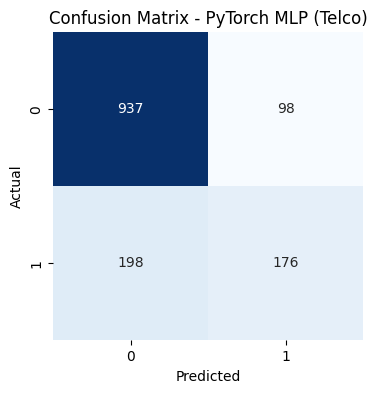

In [ ]:
cm = np.zeros((2,2), dtype=int)
for t, p_ in zip(y_true, y_pred):
    cm[t, p_] += 1
print("Confusion Matrix:\n", cm)

def plot_cm(cm, title):
    fig, ax = plt.subplots(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    plt.show()

plot_cm(cm, "Confusion Matrix - PyTorch MLP (Telco)")

## Results Summarized

Model 1 (baseline MLP)
* Accuracy = 0.7899
* Precision = 0.6423
* F1 = 0.5432

Model 2 (weighted/deeper MLP)
* Accuracy = 0.7502
* Precision = 0.5195
* F1 = 0.6247

Winner: Model 2 (weighted/deeper MLP)


## Threshold Tuning

* Lowering threshold increased recall at the cost of precision i.e Fewer missed churners at the cost of more outreach.

* Select a threshold which balances FN & FP according to retention to offer cost vs lost revenue.

In [ ]:
thresholds = np.linspace(0.3, 0.7, 9)
rows = []
for thr in thresholds:
    pred_t = (probs >= thr).astype(int)
    rows.append({
        "Threshold": thr,
        "Precision": precision(y_true, pred_t),
        "Recall": recall(y_true, pred_t),
        "F1": f1(y_true, pred_t)
    })
thr_df = pd.DataFrame(rows)
display(thr_df.sort_values("Recall", ascending=False))


,Threshold,Precision,Recall,F1
0,0.30,0.546000,0.729947,0.624714
1,0.35,0.562500,0.673797,0.613139
2,0.40,0.585678,0.612299,0.598693
3,0.45,0.611276,0.550802,0.579466
4,0.50,0.642336,0.470588,0.543210
5,0.55,0.666667,0.390374,0.492411
6,0.60,0.705882,0.320856,0.441176
7,0.65,0.731884,0.270053,0.394531
8,0.70,0.783019,0.221925,0.345833


## Business Impact

Assumptions:

* Customer lifetime value proxy and retention per contact

Net Benefit:

 SavedRevenue - ( MissedRevenue + UneccesaryCost + RetentionSpend)




In [ ]:
CUSTOMER_VALUE = 500
RETENTION_COST = 50

def business_impact(cm, customer_value=CUSTOMER_VALUE, retention_cost=RETENTION_COST):
    tn, fp = cm[0,0], cm[0,1]
    fn, tp = cm[1,0], cm[1,1]
    missed_revenue = fn * customer_value
    unnecessary_cost = fp * retention_cost
    retention_investment = tp * retention_cost
    saved_revenue = tp * customer_value
    net_benefit = saved_revenue - (missed_revenue + unnecessary_cost + retention_investment)
    return {
        "TN": tn, "FP": fp, "FN": fn, "TP": tp,
        "SavedRevenue": saved_revenue,
        "MissedRevenue": missed_revenue,
        "UnnecessaryCost": unnecessary_cost,
        "RetentionSpend": retention_investment,
        "NetBenefit": net_benefit
    }

impact = business_impact(cm)
impact


{'TN': np.int64(937),
 'FP': np.int64(98),
 'FN': np.int64(198),
 'TP': np.int64(176),
 'SavedRevenue': np.int64(88000),
 'MissedRevenue': np.int64(99000),
 'UnnecessaryCost': np.int64(4900),
 'RetentionSpend': np.int64(8800),
 'NetBenefit': np.int64(-24700)}

[Weighted] Epoch 05 | train_loss=0.7092
[Weighted] Epoch 10 | train_loss=0.6826
[Weighted] Epoch 15 | train_loss=0.6720
[Weighted] Epoch 20 | train_loss=0.6586
{'Accuracy': np.float64(0.7501774308019872), 'Precision': np.float64(0.5195035460992907), 'Recall': np.float64(0.7834224598930482), 'F1': np.float64(0.6247334754797441)}


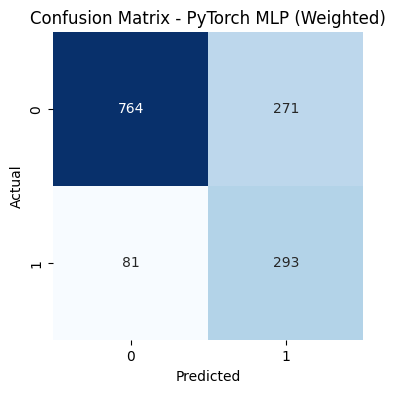

In [ ]:
pos = (y_train.values==1).sum()
neg = (y_train.values==0).sum()
pos_weight = torch.tensor([neg / max(pos,1)], dtype=torch.float32, device=device)

weighted_criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

model_w = ChurnNet(in_features=X_train_t.shape[1], hidden=[128,64], dropout=0.3).to(device)
opt_w = optim.Adam(model_w.parameters(), lr=1e-3, weight_decay=1e-5)

def train_with_weighted_loss(E=20):
    for epoch in range(1, E+1):
        model_w.train()
        total = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model_w(xb)
            loss = weighted_criterion(logits, yb)
            opt_w.zero_grad()
            loss.backward()
            opt_w.step()
            total += loss.item() * xb.size(0)
        if epoch % 5 == 0:
            print(f"[Weighted] Epoch {epoch:02d} | train_loss={total/len(train_loader.dataset):.4f}")

train_with_weighted_loss(E=20)


##Evaluation##

model_w.eval()
with torch.no_grad():
    logits_w = model_w(X_test_t.to(device)).cpu()
probs_w = torch.sigmoid(logits_w).numpy().ravel()
y_pred_w = (probs_w >= 0.5).astype(int)

acc_w = (y_pred_w == y_true).mean()
p_w   = precision(y_true, y_pred_w)
r_w   = recall(y_true, y_pred_w)
f1_w  = f1(y_true, y_pred_w)

print({"Accuracy": acc_w, "Precision": p_w, "Recall": r_w, "F1": f1_w})
cm_w = np.zeros((2,2), dtype=int)
for t, p_ in zip(y_true, y_pred_w):
    cm_w[t, p_] += 1
plot_cm(cm_w, "Confusion Matrix - PyTorch MLP (Weighted)")


## Comparing Models

 * The PyTorch MLP (weighted) will be deployed due to having a higher F1 and better Recall compared to PyTorch MLP (default).

 * This is crucial to the churn prediction where missing true churners (false negatives) can directly link to preventable revenue loss.

 * Having a higher F1 is an indication of a stronger balance between precision and recall. the recall uplift means that the model identifies more real churners for intervention.

In [ ]:
results_path = "/content/telco_pytorch_results.csv"
df_results = pd.read_csv(results_path)
display_cols = ["Model", "Accuracy", "Precision", "Recall", "F1"]
df_display = df_results[display_cols].copy()
df_display[["Accuracy","Precision","Recall","F1"]] = df_display[["Accuracy","Precision","Recall","F1"]].astype(float).round(4)
df_sorted = df_display.sort_values("F1", ascending=False).reset_index(drop=True)

winner_model = df_sorted.iloc[0]["Model"]
print(f"Winner by F1: {winner_model}")
display(df_sorted)



Winner by F1: PyTorch MLP (weighted)


,Model,Accuracy,Precision,Recall,F1
0,PyTorch MLP (weighted),0.7502,0.5195,0.7834,0.6247
1,PyTorch MLP (default),0.7899,0.6423,0.4706,0.5432


In [ ]:
results_df = pd.DataFrame([
    {"Model":"PyTorch MLP (default)", "Accuracy":acc, "Precision":p, "Recall":r, "F1":f1_},
    {"Model":"PyTorch MLP (weighted)", "Accuracy":acc_w, "Precision":p_w, "Recall":r_w, "F1":f1_w,}
]).sort_values("F1", ascending=False)
results_df.to_csv("telco_pytorch_results.csv", index=False)
np.savetxt("telco_pytorch_cm_default.txt", cm, fmt="%d")
np.savetxt("telco_pytorch_cm_weighted.txt", cm_w, fmt="%d")
print("Saved: telco_pytorch_results.csv, telco_pytorch_cm_default.txt, telco_pytorch_cm_weighted.txt")

Saved: telco_pytorch_results.csv, telco_pytorch_cm_default.txt, telco_pytorch_cm_weighted.txt


## Decision Reasoning
The PyTorch MLP (weighted) is the one selected for deployment as it delivers a higher F1 and a better recall compared to the PyTorch MLP (default). This is crucial to the prediction of missing true churners (false negatives) which directly translates into avoidable loss in revenue. A higher F1 means a stronger balance between precision and recall. The recall uplift means that the model identifies more that actual churners for interference.

## Significance of Recall

Recall tries to catch as many churners as possible as failure to do so leaves higher risk individuals unrecognized and adds to loss in revenue. F1 balances recall with precision so thaat the resources of retention are not wasted uneccesarily on non-churn individuals.

## Stengths
* Solid preprocessing for mixed data.
* Engineered features with churn drivers.
* End-to-end PyTorch training.
* Clear evaluation using confusion matrices.

## Limitations
* Feature scope misses out on usage intensity/support intensity.
* Model calibration and cost sensitive learning can be enhanced.
* Threshold requires periodic review.

## Business Implications

* With a higher recall, retention teams can contact higher amount of true churners before they leave improving save rate and customer lifetime value.

* Even if precision is slightly lower, the cost of spending resources on a few non-churn individuals will remain lesser than the value lost from missed churn individuals.

* Confusion matrices should be reviewed with retention leaders for quantification of false negatives compared to false positives and to set a threshold that fits the budget and capacity.

## Data-Driven Recommendations

1. Deployment of the weighted MLP and selection of a threshold that prioritizes recall under budget. Start with a slightly lower threshold than 0.5 to enhance sensitivity then A/B test offers levels to optimize net benefit.

2. Expansion of features with high value signals such as contract changes, billing , support intensity and frequency trends.

3. Implementation of a monthly monitoring dashboard for precision, recall, F1, drift in feature distributiions and churn. Training might be necessary quarterly or when performance drops beyond tolerance. This is standard for MLOps practice for retention models.

## Conlusion
The project delivered an end to end PyTorch Churn Prediciton pipeline. It cleans and engineers the Telco data, addresses imbalance and carries out evaluation of the model with business metrics choosing a weighted/deeper MLP for deployment as it had higher F1/recall during test.

The outcome highlights the greater ability of it to identify high risk customers before they leave. This helps with retention that helps in protection of revenue and optimizing ROI of campaigns.